In [1]:
import os
os.chdir('/Users/juli/Documents/SoSe_23/Consulting/publication/tabpfn_iml')

In [2]:
# suppress deprecation warnings
import logging
logging.captureWarnings(True)

In [4]:
import numpy as np
import pandas as pd

from tabpfniml.datasets.datasets import ArrayData

from tabpfniml.methods.ale import ALE
from tabpfniml.methods.ice_pd import ICE_PD
from tabpfniml.methods.conformal_pred import Conformal_Prediction
from tabpfniml.methods.dca import DCA
from tabpfniml.methods.loco import LOCO
from tabpfniml.methods.sensitivity import Sensitivity

Retrieve the pima diabetes dataset which we will use as a binary classification task to predict whether a patient has diabetes. 

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.



*Acknowledgement* 

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

In [5]:
diabetes = pd.read_csv('https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv')

X = diabetes.drop(columns='Outcome')
y = diabetes['Outcome'] 

diabetes_data = ArrayData("diabetes", X, y, categorical_features_idx=[0], feature_names=X.columns, id_to_target_name={1: 'Diabetes'})
diabetes_data.id_to_target_name = {1: 'Diabetes'}

In [6]:
diabetes_data.X_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
5,5,116,74,0,0,25.6,0.201,30
6,3,78,50,32,88,31.0,0.248,26
7,10,115,0,0,0,35.3,0.134,29
8,2,197,70,45,543,30.5,0.158,53
9,8,125,96,0,0,0.0,0.232,54


In [7]:
N_TRAIN = round(0.8 * diabetes_data.X_df.shape[0])
N_TEST = round(0.2 * diabetes_data.X_df.shape[0])

FEATURE_ID_OF_INTEREST = 1

### ICE and PD plots
We not use the `ICE_PD` class of our package to initialize, fit and plot the Individual Conditional Expectation (ICE) curves in black as well as their average, the Partial Dependence (PD) plot in orange for our feature of interest, the blood glucose levels in mg/dl.

It is evident that the model is more inclined to predict individuals as diabetic if their blood glucose level exceeds approximately 140 mg/dl.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


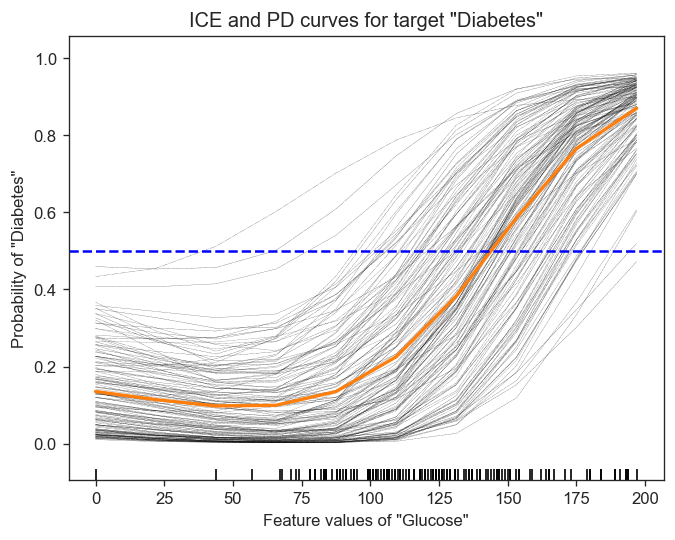

In [8]:
icepd = ICE_PD(diabetes_data,
               n_train=N_TRAIN,
               n_test=N_TEST)
icepd.fit(features=[FEATURE_ID_OF_INTEREST],
          max_levels_per_feature=10)
icepd.plot(features=[FEATURE_ID_OF_INTEREST])

### ALE plots
We now use the `ALE` class of our package to initialize, fit and plot the Accumulated Local Effects (ACE) curve for our feature of interest, the blood glucose levels in mg/dl.

While we can not directly interpret the y-axis of the ALE plot as a probability, we can still see a very similar effect to the PD plot above.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


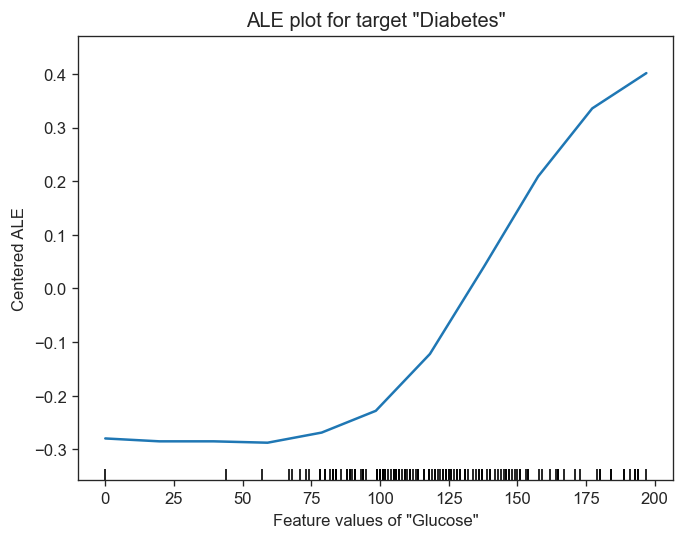

In [26]:
ale_obj = ALE(diabetes_data,
              n_train=N_TRAIN,
              n_test=N_TEST)
ale_obj.fit(features=[FEATURE_ID_OF_INTEREST],
            discretize_by_linear_spacing=True,
            center=True,
            max_intervals_per_feature=10)
ale_obj.get_ALE(feature=FEATURE_ID_OF_INTEREST)
ale_obj.plot(features=[FEATURE_ID_OF_INTEREST])

### LOCO
Leave-one-covariate-out (LOCO) is a global feature importance measure. It estimates the e↵ect of features on the predictive performance by retraining the model on a subset of features without the feature of interest. A positive value indicates that the feature improves the performance, since excluding it has led to an increase in the loss. Conversely, a very small value suggests that the feature may not be important and a negative value suggests that the feature may even have a detrimental effect on the model performance. LOCO approximately indicates if a learner requires access to a feature in the sense that the feature contains unique information that no other feature in the dataset contains.

In the plot below we can see that the blood glucose level seems to be important for TabPFN on this classification task, whereas the inclusion of the skin thickness measurements might have an adverse effect of TabPFN's performance on this task.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


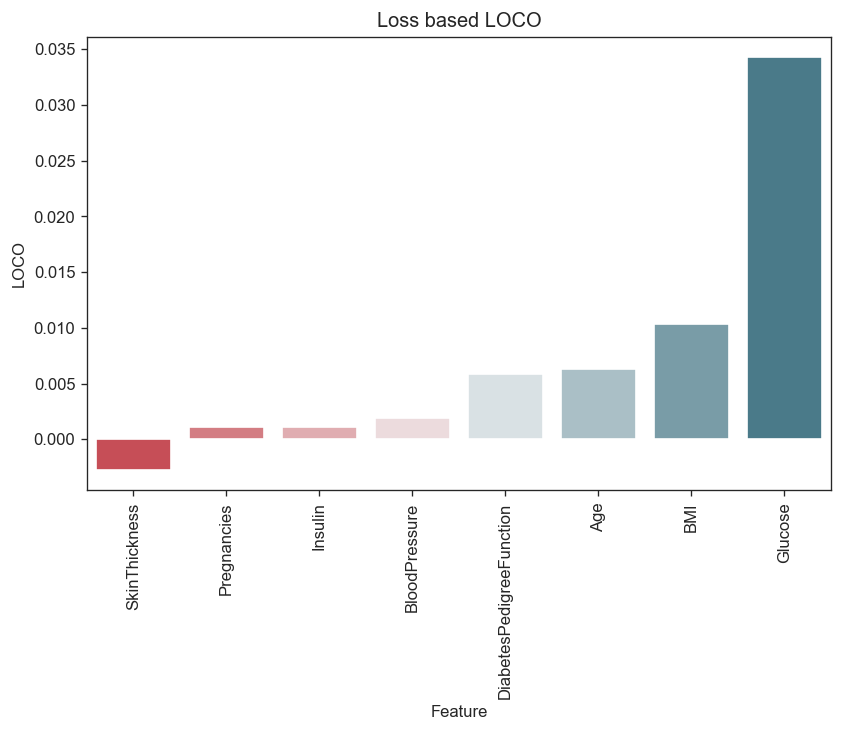

In [9]:
loco_obj = LOCO(diabetes_data,
                n_train=N_TRAIN,
                n_test=N_TEST)
loco_obj.fit()
loco_obj.plot_bar()

### Sensitivity


In [ ]:
sens_obj = Sensitivity(diabetes_data,
                       n_train=N_TRAIN,
                       n_test=N_TEST)
sens_obj.fit(compute_wrt_feature=True,
             compute_wrt_observation=True,
             loss_based=True,
             pred_based=True)

In [ ]:
sens_obj.plot_histogram(plot_pred_based=True)

In [ ]:
sens_obj.plot_histogram(plot_wrt_observation=True)

### Decision Curve Analysis
Decision Curve Analysis (DCA) is a method designed to evaluate the clinical benefits of diagnostic tests, predictive models, and decision-making strategies. Unlike traditional metrics that focus solely on the accuracy or predictive ability of a model, DCA incorporates the real-world impact of decision-making by considering the preferences and outcomes relevant to patients and healthcare providers. It does this by plotting a decision curve that illustrates the net benefit of a diagnostic test or treatment strategy across a range of threshold probabilities. In our implementation, TabPFN can be compared to a logistic regression model fit on the `marker`-feature and to other machine learning models, such as a scikit-learn `RandomForestClassifier`.

The threshold probability represents the point at which a patient or clinician would opt for treatment versus observation, balancing the risks of unnecessary intervention against the risks of not treating a condition. By comparing the net benefits of different strategies at these thresholds, DCA helps in identifying which diagnostic or treatment approach maximizes patient benefit. This analysis is particularly useful in clinical settings where decisions must consider both the potential benefits and harms of interventions, making it a valuable tool for guiding evidence-based clinical decision-making.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


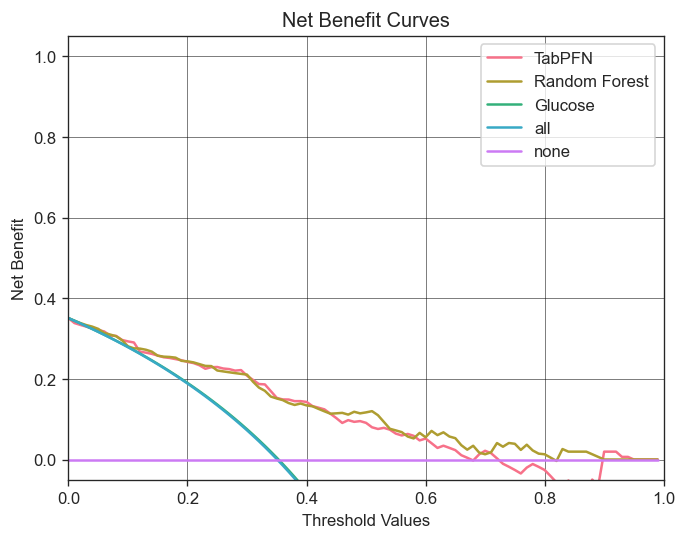

In [27]:
dca_obj = DCA(diabetes_data,
              n_train=N_TRAIN,
              n_test=N_TEST)
dca_obj.fit(marker=X.columns[FEATURE_ID_OF_INTEREST],
            random_forest=True)
dca_obj.plot(predictors=["TabPFN", "Random Forest", X.columns[FEATURE_ID_OF_INTEREST]])

### Conformal Prediction
Conformal prediction is a statistical technique that produces prediction intervals (or sets) that are valid under minimal assumptions about the data. Unlike traditional point predictions, conformal prediction quantifies the uncertainty of its predictions by providing a range of possible outcomes with a specified confidence level, given by a list of alphas: `alphas`.

Plotting our feature of interest, the blood glucose level, on the y-axis against the number of pregnancies on the x-axis, we can see that with a higher confidence level, i.e., a lower alpha, we get more than one assigned label in the prediction set for observations, where the glucose levels are in the neighborhood of 140 mg/dl, so close to the decision boundary of TabPFN.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


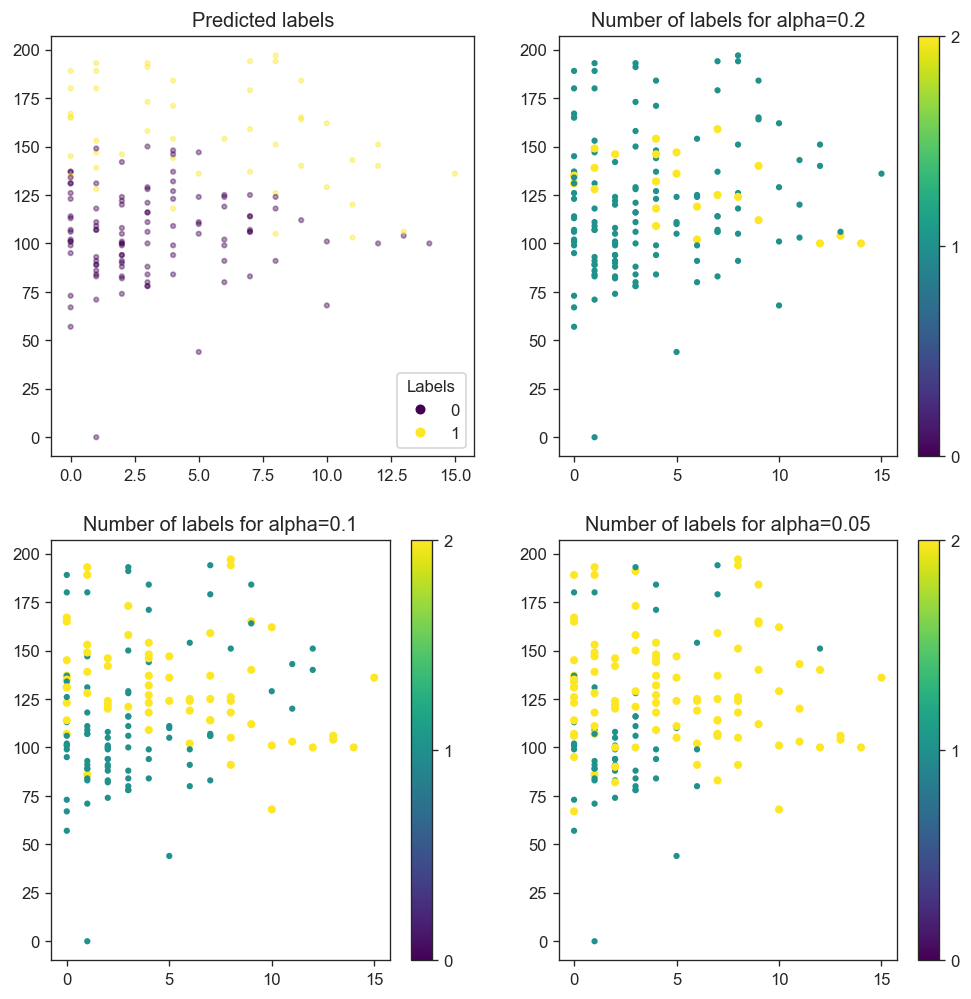

In [28]:
cp_obj = Conformal_Prediction(diabetes_data,
                              n_train=N_TRAIN,
                              n_test=N_TEST)
cp_obj.fit()
cp_obj.plot(alphas=[0.2, 0.1, 0.05])